# Лекция 6: Dask DataFrame



Dask DataFrame это большой, предназначенный для параллельной обработки, DataFrame состоящий из множества датафрэймов Pandas.  Датафрэймы, из которых соситит Dask DataFrame, представляют собой фрагменты большого DataFrame, разбитого по индексу. Они могут располагаться на диске, для вычислений с данными, большими, чем оперативная память, как на одной машине, так и на разных машинах, входящих в кластер. 

Dask DataFrame имеет **интерфейс, максимально похожий на Pandas DataFrame**, но одна операция с Dask DataFrame порождает множество операций с датафрэймами Pandas, из которых состоит Dask DataFrame. Управляется процедура вычсилений с помощью инфраструкутры Dask, которая позволяет распараллеливать рассчеты и выполнять рассчеты поэтапно, что дает возможность обрабатывать объемы данных, большие чем оператмивная память.

<img src="dask-dataframe.svg" alt="Drawing" style="width: 200px;"/>

Каждый блок данных в разбиении называется сегментом (partition) а его верхняя и нижняя граница разделителем (division). Dask может хранить информацию о разделителях. Разбиение на сегменты важно для выполнения эффективных запросов.

Сегменты станут важны при написании собственных функций, которые необходимо применить к элементам в Dask DataFrame.


Dask DataFrame целесообразно использовать для анализа и обработки данных, имеющих табличный формат и имеющих размер больший, чем оперативная память. Если операции с вашим массивом данных в Pandas приводят к ошибкам MemoryError, то использование Dask DataFrame позволяет обойти эту проблему.

Операции Dask DataFrame используют вызовы функций pandas. Обычно они выполняются с той же скоростью что и операции в pandas. Небольшые дополнительные накладные расходы добавляет инфраструктура Dask (окло 1 мс. на задачу, при выполнении достаточно курпных задач этими издержками можно пренебречь). 

По умолчанию Dask DataFrame использует планировщик "multi-threaded". Этот планировщик демонстрирует параллелизм когда операции Pandas или используемого им NumPy освобождают GIL. В целом, в Pandas GIL освобождается реже, чем в NumPy. Поэтому ожидаемый прирост скорости от использования множества ядер для Dask DataFrame меньше, чем при использование Dask Array. Постепенно количество операций Pandas, освобождающих GIL увеличиывается, что будет положительно сказаываться на приросте производительности операций в Dask DataFrame.

Планировщик задач "distributed" позволяет исполнять одно выражение с датафрэймом на всех узлах кластера (или всех ядрах одного компьютера) и не ограничен необходимостью освобождать GIL. Обратной стороной использования такого подхода является отказ от использования разделяемой памяти и, как следствие, накладные расходы на обмен данными.

В частности, при работе с текстовыми данными переход на планировщик "distributed" позволяет получить приращение производительности как на кластере, так и на одном компьютере.

Для эффективной обработки больших данных с помощью планировщика "distributed" рекомендуется:
* загружать данные методом `read_csv` из хранилища, доступного для каждого узла (например, такого как amazon S3)
* организовывать вычисления, так, чтобы они начинались с отбора данных для обработки, их фильтрации и преобразований и заврешались операциями, требующими обмена данными между узлами


* We call each chunk a partition, and the upper / lower bounds are divisions. Dask can store information about the divisions. We'll cover this in more detail in Distributed DataFrames. For now, partitions come up when you write custom functions to apply to Dask DataFrames

### Ограничения при работе с Dask DataFrame

Pandas обладает существенно большим функционалом, чем поддерживает Dask DataFrame. 

#### Какие функции не работают?

Dask DataFrame покрывает только небольшую но наиболее востребовыванную часть API pandas. Причинами такого положения являются, то, что:

* Pandas обладает гигантским API
* Некоторые операции по своей природе сложно выполнить параллельно (например, сортировку)

Кроме того, некоторые важные операции, такие как ``set_index`` работают, но существенно медленнее, чем в Pandas, так как по своей сути требуют группировки (shuffling) данных и могут потребовать записи данных на диск.

#### Какие функции определенно работают

* Тривиально распараллеливаемые операции (работают быстро):
    *  Elementwise operations:  ``df.x + df.y``
    *  Row-wise selections:  ``df[df.x > 0]``
    *  Loc:  ``df.loc[4.0:10.5]``
    *  Common aggregations:  ``df.x.max()``
    *  Is in:  ``df[df.x.isin([1, 2, 3])]``
    *  Datetime/string accessors:  ``df.timestamp.month``
* Операции, требующие не тривиальной организации параллельной работы (работают быстро):
    *  groupby-aggregate (with common aggregations): ``df.groupby(df.x).y.max()``
    *  value_counts:  ``df.x.value_counts``
    *  Drop duplicates:  ``df.x.drop_duplicates()``
    *  Join on index:  ``dd.merge(df1, df2, left_index=True, right_index=True)``
* Операции требующие группировки (shuffle) (медленно, если не по индексу)
    *  Set index:  ``df.set_index(df.x)``
    *  groupby-apply (with anything):  ``df.groupby(df.x).apply(myfunc)``
    *  Join not on the index:  ``pd.merge(df1, df2, on='name')``
* Операции загрузки данных
    *  Files: ``dd.read_csv, dd.read_parquet, dd.read_json, dd.read_orc``, etc.
    *  Pandas: ``dd.from_pandas``
    *  Anything supporting numpy slicing: ``dd.from_array``
    *  From any set of functions creating sub dataframes via ``dd.from_delayed``.
    *  Dask.bag: ``mybag.to_dataframe(columns=[...])``

**Документация**

*  [Dask DataFrame documentation](http://dask.pydata.org/en/latest/dataframe.html)
*  [Pandas documentation](http://pandas.pydata.org/)

## Подготовка и загрузка данных

In [2]:
import pandas as pd
import numpy as np
import operator

In [3]:
import os
import dask
import dask.dataframe as dd

In [3]:
from prep import accounts_csvs
# генерация искуственного набора данных:
accounts_csvs(6, 1000000, 500)

Create CSV accounts for dataframe exercise


In [4]:
filename = os.path.join('data', 'accounts.*.csv')
filename

'data\\accounts.*.csv'

In [5]:
# Чтение всех файлов CSV, соответствующих шаблону, в Dask DataFrame:
df = dd.read_csv(filename)

In [6]:
df.head()

,id,names,amount
0,185,Victor,2556
1,185,Victor,2461
2,487,Frank,-524
3,47,Sarah,724
4,190,Quinn,74


#### Задание типов данных

In [26]:
df.dtypes

id         int64
names     object
amount     int64
dtype: object

В отличие от функции `pandas.read_csv`, которая читает весь файл, перед тем, как автоматически устанавливает типы для столбцов, `dask.dataframe.read_csv` читает только фрагмент из начала файла (или первый файл, из множества файлов, соотвтетствующих шаблону glob). Установленные таким образом типы данных для столбцов потом применяются для загружаемых данных во всех сегментах. 

В случае, если начальный фрагмент данных не полностью реперезантитвен, типы столбцов, установленные автоматически, могут быть некорректными и приводить к ошибкам загрузки данных. Существует несколько способов решения этой проблемы:

- **Рекомендуемый способ:** явное указание типов столбцов с помощью параметра `dtype` ("Явное лучше, чем неявное"). Это наиболее надежный и наиболее эффективный с точки зрения производительности подход. 
- Увеличение размера фрагмента, по которому делается вывод о типах столбцов, через задание параметра `sample` (размер в байтах).
- Используя параметр `assume_missing` можно указать Dask на необходимость исползования `float` для столбцов содержащих значения `int`, что позволит хранить в этих столбцах значения `np.NaN` для пропущенных значений.

In [27]:
df = dd.read_csv(filename,
                dtype={'id': int,
                        'names': str,
                        'amount': int})

df.head()

,id,names,amount
0,187,Ingrid,457
1,346,Ursula,747
2,350,Dan,1175
3,464,Zelda,-571
4,431,Wendy,4534


In [29]:
# TODO:
df.tail()  # this fails

,id,names,amount
999995,43,Dan,933
999996,431,Wendy,4913
999997,168,Hannah,323
999998,308,Norbert,-14
999999,353,Ingrid,366


In [7]:
df.dtypes

id         int32
names     object
amount     int32
dtype: object

TODO:

meta:pd.DataFrame, pd.Series, dict, iterable, tuple, optional
An empty pd.DataFrame or pd.Series that matches the dtypes and column names of the output. This metadata is necessary for many algorithms in dask dataframe to work. For ease of use, some alternative inputs are also available. Instead of a DataFrame, a dict of {name: dtype} or iterable of (name, dtype) can be provided. Instead of a series, a tuple of (name, dtype) can be used. If not provided, dask will try to infer the metadata. This may lead to unexpected results, so providing meta is recommended. For more information, see dask.dataframe.utils.make_meta.

#### Обработка данных в Dask dataframe

In [14]:
len(df)

6000000

Порядок работы:
* Функция `read_csv` нашла все файлы, подходящие по шаблону.
* Dataframe был сформирован из сегментов (в данном случае по одному сегменту на файл).
* Выполненение функции `len` породило задачи для каждого сегмента. 
* Управление выполнением задач выполнял Dask.
* Данные из каждого файла были загружены в свой Pandas DataFrame и в каждом из них была выполнена функция `len`.
* Итоговая длина Dask dataframe была вычислена из слогаемых полученных для каждого из сегментов.

In [18]:
m = df.amount.max()

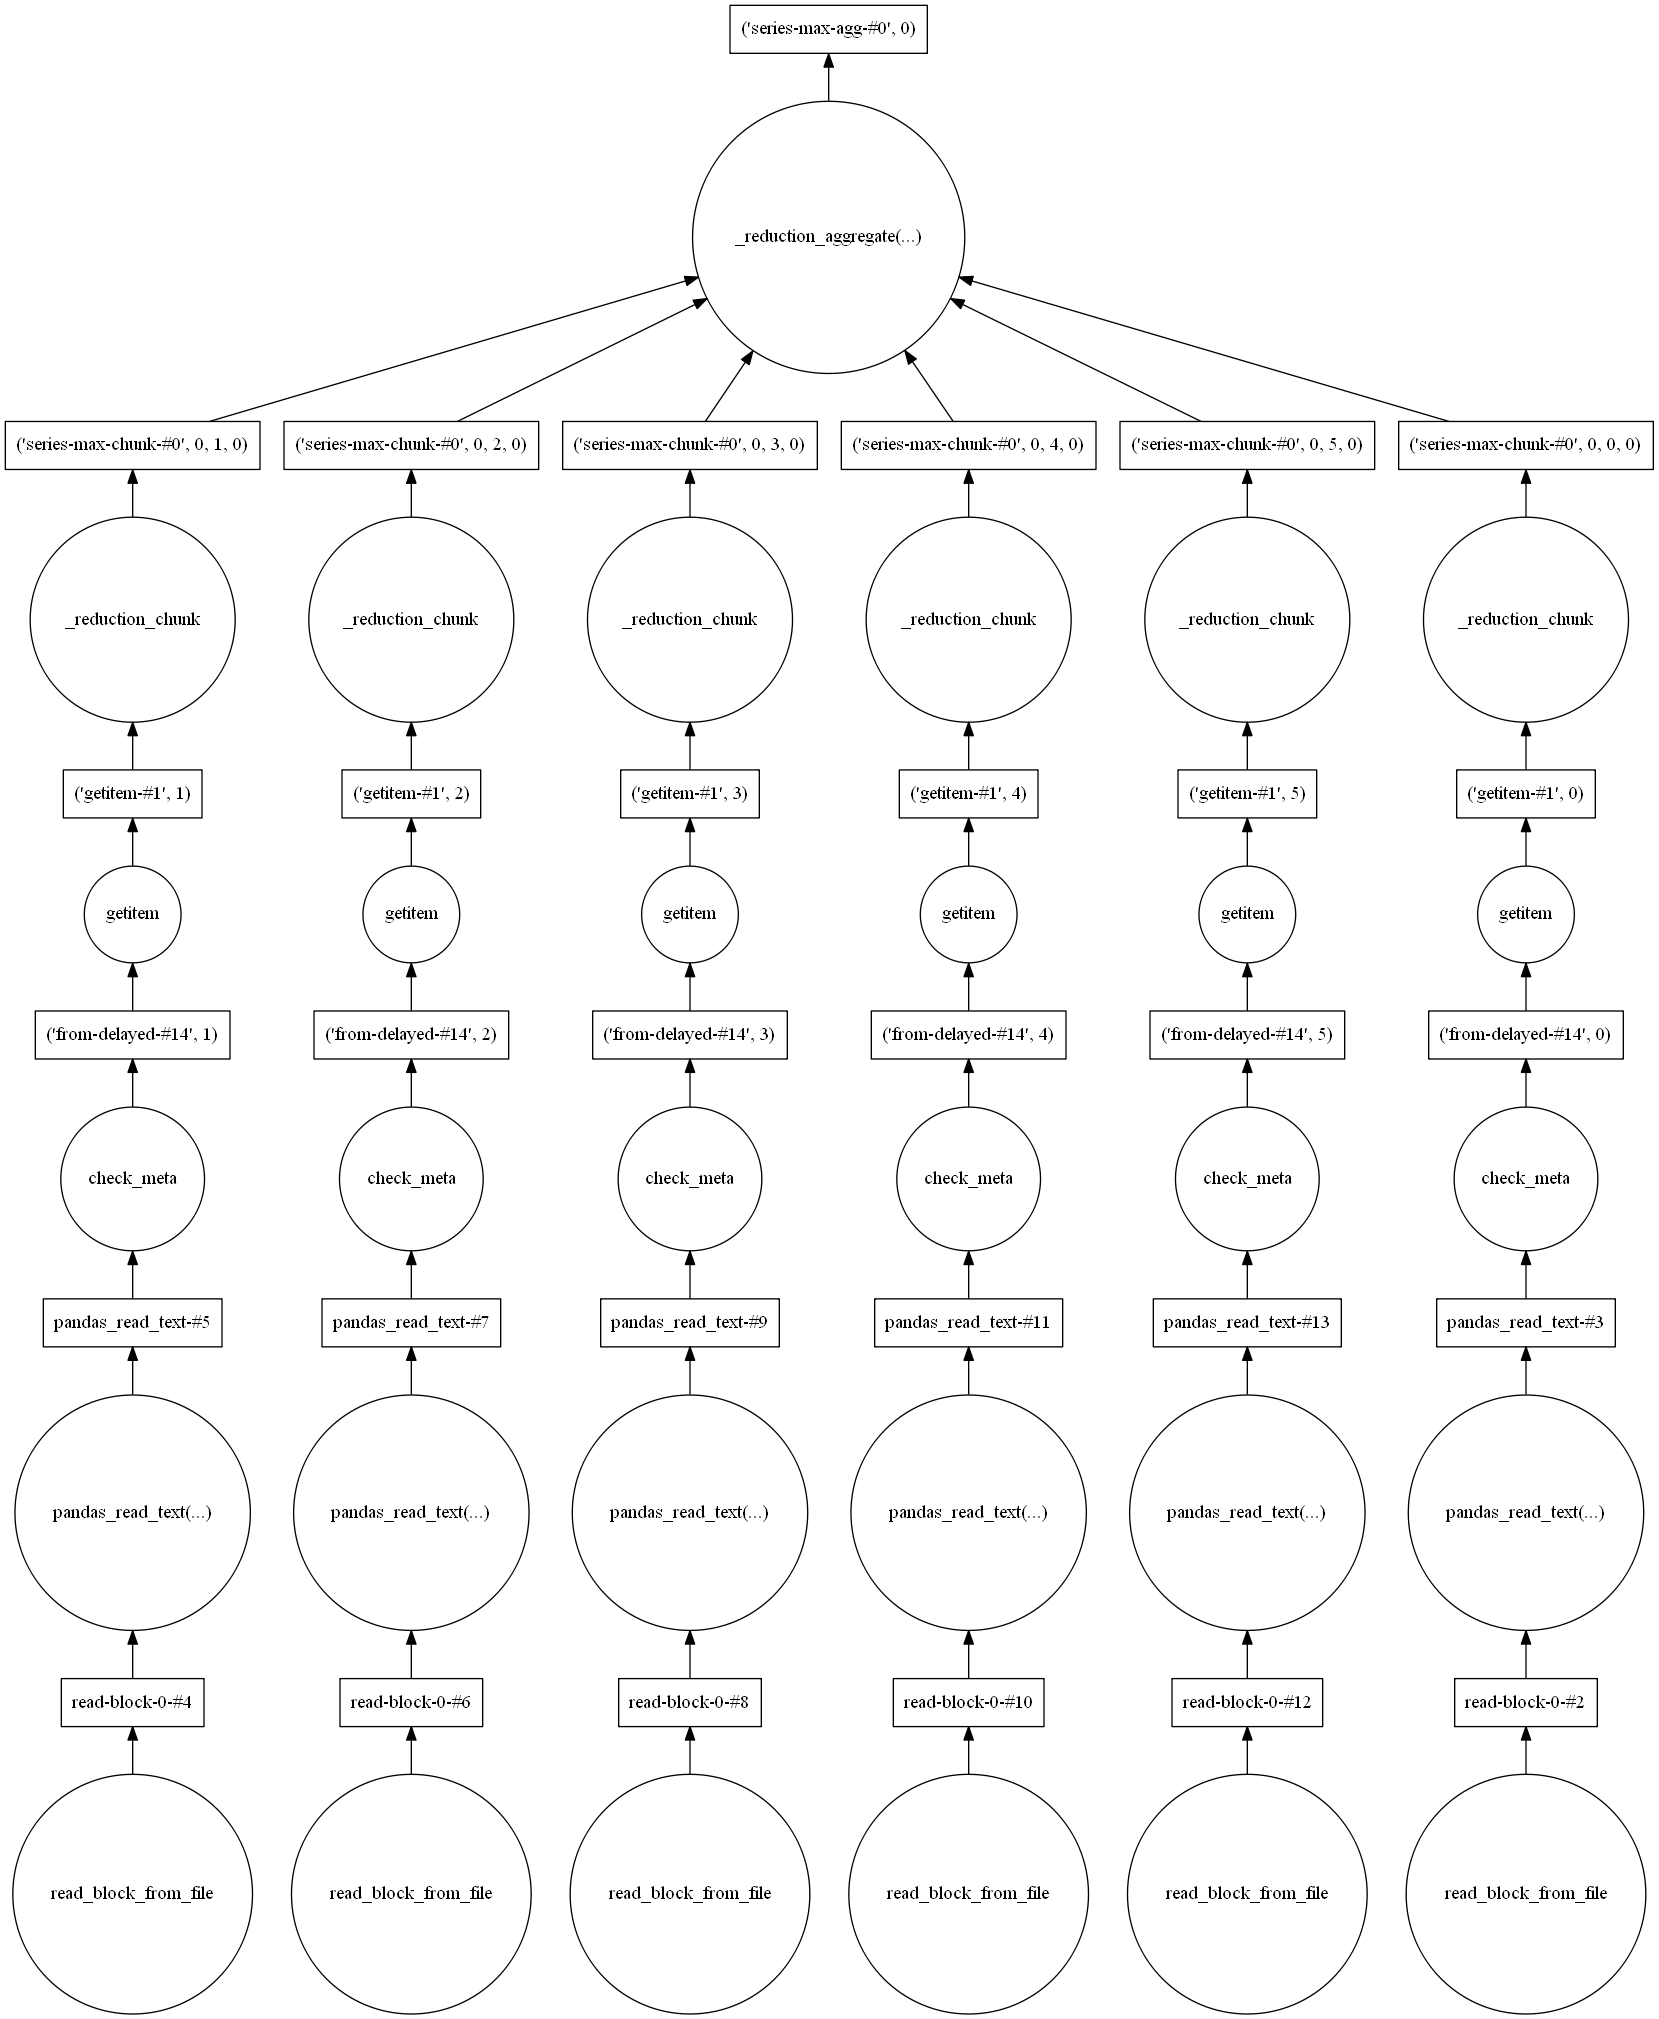

In [19]:
m.visualize()

In [21]:
%%time 
m.compute()

Wall time: 2.92 s


10629

In [30]:
# сколько всего положительных значений:
len(df[df.amount > 0])

4864173

#### Совместное использование промежуточных результатов

При работе с DataFrame некоторые вычисления могут проделываться более одного раза. Для большинства операций `dask.dataframe` сохранияет промежуточные результаты так, что они могут повторно использоваться. Но для этого эти промежуточные результаты должны рассматриваться в рамках одного процесса вычислений, запущенного вызовом `compute` (или его неявным аналогом).


часть вычислений мо

When computing all of the above, we sometimes did the same operation more than once. For most operations, `dask.dataframe` hashes the arguments, allowing duplicate computations to be shared, and only computed once.

For example, lets compute the mean and standard deviation for departure delay of all non-canceled flights. Since dask operations are lazy, those values aren't the final results yet. They're just the recipe require to get the result.

If we compute them with two calls to compute, there is no sharing of intermediate computations.

Рассмотрим пример рассчета суммы и среднего значения для одного столбца `dask.dataframe`. 

In [42]:
df_sum = df[df.amount > 0].amount.sum()
df_mean = df[df.amount > 0].amount.mean()

In [43]:
%%time
df_sum.compute()

Wall time: 2.59 s


5855769421

In [44]:
%%time
df_mean.compute()

Wall time: 2.4 s


1203.8571450892064

Для рассчета среднего значения используется суммирование по столбцу, что и составляет основную трудоемкость операции. (не случайно выполнение каждой из функций занимает примерно одно время). Использование промежуточных результатов суммирования для вычисления среднего значения могло бы существенно его ускорить. Для этого обе функции нужно рассчитать в рамках одного вызова функции `compute`.

In [45]:
%%time
s, m  = dask.compute(df_sum, df_mean)
s, m

Wall time: 2.43 s


Использование `dask.compute` для одновременного рассчета двух функций сократило время рассчета в 2 раза. Это произошло из-за того, что графы зависимостей задач для вычисления каждой функции были объеденины, что позволило однократно выполнять вычисления встречающиеся в каждом из графов.

В частности однократно выполнялись операции: 

* загрузка данных из файла (функция `read_csv`)
* фильтарция (`df[df.amount > 0]`)
* часть операций в свертках (функции `sum`, `count`)

Для того, чтобы увидеть как были объединены графы зависимостей задач можно исопльзовать функцию `dask.visualize` (для подробного рассмотрения графа можно использовать экспорт в pdf файл с помощью параметра `filename='graph.pdf'`)

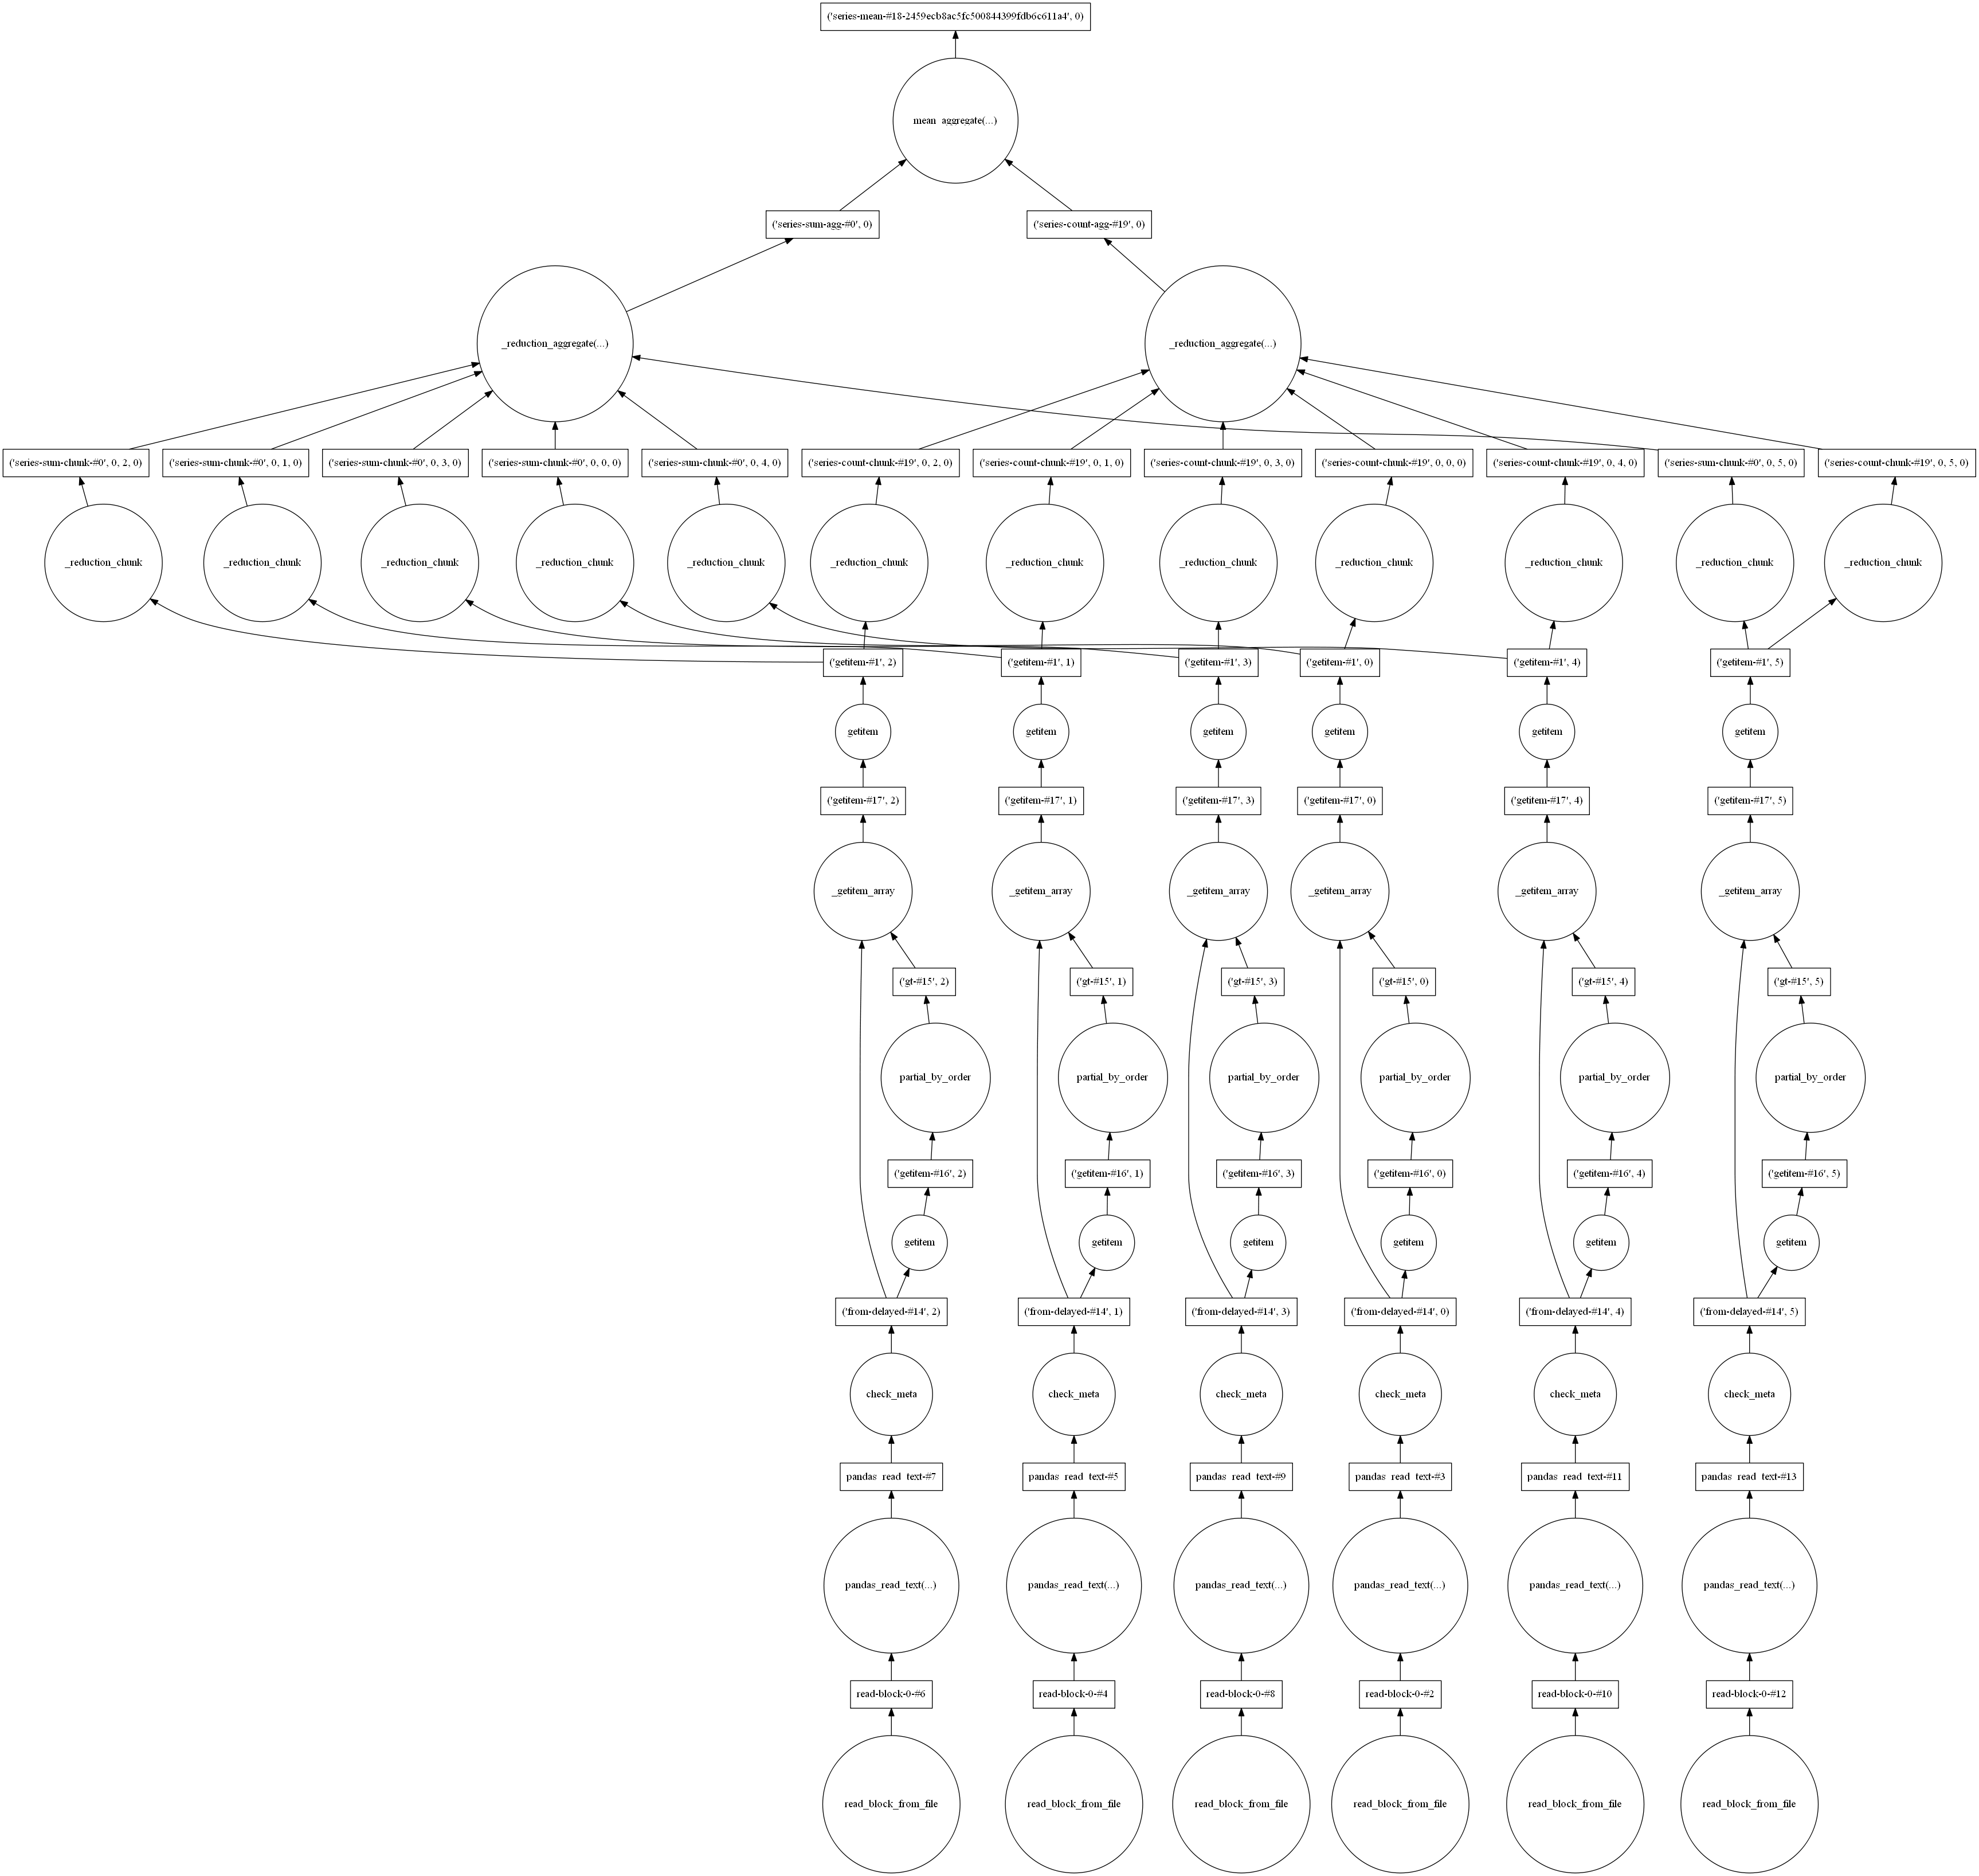

In [46]:
dask.visualize(df_sum, df_mean)

In [47]:
dask.visualize(df_sum, df_mean, filename='sum_mean_vis.pdf')

#### Mаппинг в Dask.DataFrame

В `dask.dataframe` есть несколько функций для применения собственных функций к данным, хранящихся в dataframe. Для работы с Series в Dask имеются следующие функции:

* `map` мэппинг значений из series используя сопосотавление из словаря, другой серии или функции
* `apply` применение более сложных функций к элементам из series
* `map_partitions` применение функции к каждой секции `Dask.DataFrame`
* `map_overlap` применение функции к каждой секции `Dask.DataFrame` с возможностью доступа к значениям из смежных секций.

`map(arg, na_action=None, meta='__no_default__')` мэппинг значений из series используя сопосотавление из словаря, другой серии или функции

Параметры:	
* arg: функция, словарь или серия - определяет преобразование элементов
* na_action: {None, ‘ignore’} при значении ‘ignore’, значения NA распространяеются без применения преобразования

meta: метаданные возвращаемого результата, определяющие структуру и типы столбцов возвращаемого значения, метаданные могут быть заданы одним из из типов: pd.DataFrame, pd.Series, dict, iterable, tuple, optional. Пустой pd.DataFrame или pd.Series имеющие последовательность, названия и типы столбцов (dtype) соответствующие возвращаемому значению. Альтернативой может быть словарь вида {name: dtype} или итерируемый объект состоящий из картежей (name, dtype). В случае отсутствия метаданных Dask попытается автоматически их определить, что может привести к непредвиденным ошибкам.

In [7]:
size = 8
abc = list(map(chr, range(ord('a'), ord('a') + size)))
abc

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h']

In [8]:
df1 = pd.DataFrame(data=list(zip(abc, [np.random.randint(5) for v in range(size)])), 
                   index=list(range(size)), columns=['val','rnd'])
df1

,val,rnd
0,a,4
1,b,3
2,c,4
3,d,0
4,e,1
5,f,0
6,g,4
7,h,2


In [9]:
ddf1 = dd.from_pandas(df1, npartitions=2)

In [10]:
ddf1.dtypes

val    object
rnd     int64
dtype: object

In [69]:
# если структура DataFrame не меняется, то в качесвте метаданных возвращаемого результата можно передать исходные данные
ddf2 = ddf1['val'].map(lambda v: v*2, meta=ddf1['val']).compute()
ddf2

0    aa
1    bb
2    cc
3    dd
4    ee
5    ff
6    gg
7    hh
Name: val, dtype: object

In [70]:
d = dict(zip(abc, map(ord, abc)))
d

{'a': 97, 'b': 98, 'c': 99, 'd': 100, 'e': 101, 'f': 102, 'g': 103, 'h': 104}

In [72]:
ddf3 = ddf1['val'].map(d, meta=ddf1['val']).compute()
ddf3

0     97
1     98
2     99
3    100
4    101
5    102
6    103
7    104
Name: val, dtype: int64

In [66]:
ddf.dtypes

val    object
dtype: object

In [74]:
df2 = pd.DataFrame(data=list(range(1, size*10, 10)), index=abc, columns=['new_val'])
df2

,new_val
a,1
b,11
c,21
d,31
e,41
f,51
g,61
h,71


In [75]:
ddf4 = ddf1['val'].map(df2['new_val'], meta=ddf1['val']).compute()
ddf4

0     1
1    11
2    21
3    31
4    41
5    51
6    61
7    71
Name: val, dtype: int64

------

`apply` позволяет передавать фиксированные значения в позиционные и именнованные параметры применяемой функции через аргумент `args` и произвольные именованные параметры `**kwds`.

In [11]:
def s_mult(s, m, end=''):
    return s * m + end

In [12]:
ddf1['val'].apply(s_mult, args=(3,), end='-', meta=ddf1['val']).compute()

0    aaa-
1    bbb-
2    ccc-
3    ddd-
4    eee-
5    fff-
6    ggg-
7    hhh-
Name: val, dtype: object

Для работы с DataFrame в Dask имеются следующие функции:

* `apply` применение функции по строкам
* `applymap` поэлементный мэппинг значений для всех значений в DataFrame
* `map_partitions` применение функции к каждой секции `Dask.DataFrame`
* `map_overlap` применение функции к каждой секции `Dask.DataFrame` с возможностью доступа к значениям из смежных секций
* `pipe` выполнение цепочки операций по применению функций к DataFrame, Series или объектам GroupBy 

In [13]:
def name_add(row, n_len, val=1):
    if len(row['names']) > n_len:
        row['amount'] += val
    return row

In [14]:
df.head(15)

,id,names,amount
0,185,Victor,2556
1,185,Victor,2461
2,487,Frank,-524
3,47,Sarah,724
4,190,Quinn,74
5,19,Ingrid,3110
6,180,Frank,258
7,47,Sarah,453
8,338,Wendy,3838
9,277,Hannah,266


In [15]:
# apply аналогична работе в DataFrame, но поддерживате работу только по строкам (axis=1)
df_a = df.apply(name_add, axis=1, args=(4,), val=1000, meta=df)

In [16]:
df_a.head()

,id,names,amount
0,185,Victor,3556
1,185,Victor,3461
2,487,Frank,476
3,47,Sarah,1724
4,190,Quinn,1074


-----

`map_partitions(func, *args, **kwargs)` - применение функции к каждой секции `Dask.DataFrame`

Параметры:
func - функция, которая применяется к каждому Pandas.DataFrame
args, kwargs - параметры func. Среди kwargs может передаваться параметр meta, содержащий метаданные возвращаемого результата.

`map_partitions` может применяться для применения функций Pandas.DataFrame не реализованных в Dask или для исопользования удобных выражений Pandas для рассчетов.

In [88]:
df.dtypes

id         int32
names     object
amount     int32
dtype: object

In [90]:
df_mp = df.map_partitions(lambda df: df.assign(val=df.id + df.amount), 
                  meta={'id': 'i4', 'names': 'object', 'amount': 'i4', 'val': 'i4'})

In [92]:
r = df_mp.compute()
r.head()

,id,names,amount,val
0,187,Ingrid,457,644
1,346,Ursula,747,1093
2,350,Dan,1175,1525
3,464,Zelda,-571,-107
4,431,Wendy,4534,4965


In [97]:
# использование map_partitions для полученяи заголовков всех секторов:
df.map_partitions(pd.DataFrame.head, 3, meta=df).compute()

,id,names,amount
0,187,Ingrid,457
1,346,Ursula,747
2,350,Dan,1175
0,165,Edith,5389
1,367,Ray,1282
2,485,Victor,1043
0,388,Xavier,0
1,425,Ray,196
2,222,Oliver,27
0,234,Bob,-224


-----

`pipe(func, *args, **kwargs)` выполнение цепочки операций по применению функций к DataFrame, Series или объектам GroupBy. Aналогично `apply` применяет функцию `func` с аргументами `*args` и `**kwargs`. Позволяет последовательное применение функции записывать вместо вида: 

`f(g(h(df), arg1=a), arg2=b, arg3=c)`

в виде:

`(df.pipe(h)  
   .pipe(g, arg1=a)
   .pipe(f, arg2=b, arg3=c)
 )`

In [109]:
ddf1.head(3)

,val,rnd
0,a,2
1,b,2
2,c,1


In [110]:
def npow(a, b):
    return a ** b

In [114]:
# конструкция (npow, 'b') позволяет передавать данные не в первый аргумент функции:
ddf1['rnd'].pipe((npow, 'b'), a=2).pipe(operator.floordiv, 1).compute()

0     4
1     4
2     2
3     4
4     1
5    16
6    16
7     2
Name: rnd, dtype: int64

#### Rolling Operations

http://docs.dask.org/en/latest/dataframe-api.html#dask.dataframe.DataFrame.map_overlap

In [133]:
size = 10
df_r = pd.DataFrame({'x': list(range(1, size*2, 2)), 'y': list(range(size))})
df_r

,x,y
0,1,0
1,3,1
2,5,2
3,7,3
4,9,4
5,11,5
6,13,6
7,15,7
8,17,8
9,19,9


In [135]:
ddf_r = dd.from_pandas(df_r, npartitions=2)

In [136]:
ddf_r.map_overlap(lambda df: df.rolling(2).sum(), 2, 0).compute()

,x,y
0,NaN,NaN
1,4.0,1.0
2,8.0,3.0
3,12.0,5.0
4,16.0,7.0
5,20.0,9.0
6,24.0,11.0
7,28.0,13.0
8,32.0,15.0
9,36.0,17.0


In [139]:
ddf_r.map_overlap(lambda df: df.rolling(3, center=True).mean(), 1, 1).compute()

,x,y
0,NaN,NaN
1,3.0,1.0
2,5.0,2.0
3,7.0,3.0
4,9.0,4.0
5,11.0,5.0
6,13.0,6.0
7,15.0,7.0
8,17.0,8.0
9,NaN,NaN


#### GroupBy

In [122]:
%%time
df.groupby('id').id.count().compute()

Wall time: 2.4 s


id
0       9030
1       9507
2       1457
3      11443
4      19511
5       2835
6      10624
7      18200
8       6946
9       4202
10      6521
11      3582
12     10978
13     20039
14      3544
15     32400
16     10139
17     19238
18      9997
19      1393
20     17865
21      1267
22      1987
23      3968
24     11802
25       187
26     12267
27     14135
28      1595
29     18296
       ...  
470     4653
471     7364
472    11652
473     4547
474     8739
475    19373
476     2752
477    40536
478    47956
479     5161
480     3510
481    25305
482     3641
483    12901
484     5080
485    68333
486     1791
487     3585
488    12958
489    28154
490     6004
491    18930
492      852
493     1892
494     2282
495     6211
496     1587
497    22337
498      347
499    20569
Name: id, Length: 500, dtype: int64

| Функция | Краткое описание |
|------|------|
|`DataFrameGroupBy.aggregate(arg[, …])'| Aggregate using one or more operations over the specified axis.
|`DataFrameGroupBy.apply(func, *args, **kwargs)'| Parallel version of pandas GroupBy.apply
|`DataFrameGroupBy.count([split_every, split_out])'| Compute count of group, excluding missing values
|`DataFrameGroupBy.cumcount([axis])'| Number each item in each group from 0 to the length of that group - 1.
|`DataFrameGroupBy.cumprod([axis])'| Cumulative product for each group
|`DataFrameGroupBy.cumsum([axis])'| Cumulative sum for each group
|`DataFrameGroupBy.get_group(key)'| Constructs NDFrame from group with provided name
|`DataFrameGroupBy.max([split_every, split_out])'| Compute max of group values
|`DataFrameGroupBy.mean([split_every, split_out])'| Compute mean of groups, excluding missing values
|`DataFrameGroupBy.min([split_every, split_out])'| Compute min of group values
|`DataFrameGroupBy.size([split_every, split_out])'| Compute group sizes
|`DataFrameGroupBy.std([ddof, split_every, …])'| Compute standard deviation of groups, excluding missing values
|`DataFrameGroupBy.sum([split_every, split_out])'| Compute sum of group values
|`DataFrameGroupBy.var([ddof, split_every, …])'| Compute variance of groups, excluding missing values
|`DataFrameGroupBy.first([split_every, split_out])'| Compute first of group values
|`DataFrameGroupBy.last([split_every, split_out])'| Compute last of group values

In [131]:
%%time
# сколько положительных значений для каждого из имен:
df[df.amount > 0].groupby('names').names.count().compute()

Wall time: 4.83 s


names
Alice       194320
Bob         178511
Charlie     269656
Dan         127348
Edith       174757
Frank       221728
George      143828
Hannah      176715
Ingrid      307571
Jerry       181694
Kevin       123373
Laura       195132
Michael     277878
Norbert     230327
Oliver      205323
Patricia    152670
Quinn        92387
Ray         214780
Sarah       207288
Tim         166622
Ursula      189445
Victor      174324
Wendy       100392
Xavier      303768
Yvonne      173700
Zelda        80636
Name: names, dtype: int64

In [132]:
%%time
# aggregage позволяет выполнить одновременно несколько агрегирующих операций при группировке:
df[df.amount > 0].groupby('names').amount.aggregage(['min', 'max']).compute()

Wall time: 4.03 s


,min,max
names,,
Alice,1,3456
Bob,1,5337
Charlie,1,3366
Dan,1,3256
Edith,1,7356
Frank,1,5989
George,1,4361
Hannah,1,2475
Ingrid,117,6157


In [130]:
# группировку можно производить при помощи функции, которая будет применяться к индексу:
df.groupby(lambda df_ind: df_ind % 10).amount.max().compute()

0    10457
1    10385
2    10427
3    10629
4    10196
5    10370
6    10477
7    10279
8    10450
9    10485
Name: amount, dtype: int32

In [32]:
df.groupby('names').amount.mean().compute()

names
Alice       1117.879523
Bob          825.805351
Charlie     1055.778711
Dan          471.027284
Edith       1674.873425
Frank        553.868167
George       797.592038
Hannah       -99.250233
Ingrid      1037.455586
Jerry        676.200503
Kevin        652.536256
Laura       1351.642707
Michael     1396.056457
Norbert     1236.411505
Oliver       542.008975
Patricia     894.189917
Quinn       1933.256519
Ray         1040.518208
Sarah        682.514225
Tim         1133.231264
Ursula       627.547111
Victor       753.775806
Wendy       1183.128248
Xavier      1136.236591
Yvonne       762.676188
Zelda       -130.329877
Name: amount, dtype: float64

TODO: from Dask Array

TODO: reindex

TODO: join
